In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import os, keras
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K

from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *
from keras.optimizers import *

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import zipfile
from skimage import io
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/carvana-image-masking-challenge/train_masks.zip
/kaggle/input/carvana-image-masking-challenge/29bb3ece3180_11.jpg
/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip
/kaggle/input/carvana-image-masking-challenge/train.zip
/kaggle/input/carvana-image-masking-challenge/metadata.csv.zip
/kaggle/input/carvana-image-masking-challenge/sample_submission.csv.zip
/kaggle/input/carvana-image-masking-challenge/test.zip
/kaggle/input/carvana-image-masking-challenge/test_hq.zip
/kaggle/input/carvana-image-masking-challenge/train_hq.zip
/kaggle/input/samplecar/sample-00005_cut.jpg
/kaggle/input/samplecar/sample-00007_cut.jpg
/kaggle/input/samplecar/sample-00006.jpg
/kaggle/input/samplecar/sample-00002_cut.jpg
/kaggle/input/samplecar/sample-00010_cut.jpg
/kaggle/input/samplecar/sample-00001.jpg
/kaggle/input/samplecar/sample-00003_cut.jpg
/kaggle/input/samplecar/sample-00014.jpg
/kaggle/input/samplecar/sample-00015.jpg
/kaggle/input/samplecar/sample-00012.jpg
/kaggle/input

In [2]:
#Input directories
trainHQ_zip_path = '/kaggle/input/carvana-image-masking-challenge/train_hq.zip'
masks_zip_path = '/kaggle/input/carvana-image-masking-challenge/train_masks.zip'



if not os.path.exists("../working/X_train"):
    PATH_TRAIN = os.makedirs("../working/X_train")

    
if not os.path.exists("../working/y_train"):
    PATH_TRAIN_MASK = os.makedirs("../working/y_train")
    
if not os.path.exists("../working/y_train"):
    PATH_TRAIN_MASK = os.makedirs("../working/y_train")
    

if not os.path.exists("../working/X_val"):
    PATH_VAL= os.makedirs("../working/X_val")

    
if not os.path.exists("../working/y_val"):
    PATH_VAL_MASK = os.makedirs("../working/y_val")
    
if not os.path.exists("../working/X_val"):
    PATH_VAL = os.makedirs("../working/X_val")
    
if not os.path.exists("../working/X_test/"):
    PATH_TEST = os.makedirs("../working/X_test/")
    
if not os.path.exists("../working/y_test"):
    PATH_TEST_MASK = os.makedirs("../working/y_test")
    
    


In [3]:


#Extract train images.
with zipfile.ZipFile(trainHQ_zip_path,'r') as zip_ref:
    zip_ref.extractall('/kaggle/working')
    
    
#Extract train masks/labels.
with zipfile.ZipFile(masks_zip_path,'r') as zip_ref:
    zip_ref.extractall('/kaggle/working')
    
    
# data_size = len(os.listdir('/kaggle/currentWorkingDir/train_hq'))

print('Number of train images: ', len(os.listdir('/kaggle/working/train_hq')))
print('Number of train masks: ', len(os.listdir('/kaggle/working/train_masks')))

Number of train images:  5088
Number of train masks:  5088


In [4]:
#Display ids for images and masks.
car_ids = sorted(os.listdir('/kaggle/working/train_hq'))
mask_ids = sorted(os.listdir('/kaggle/working/train_masks'))

index = np.random.choice(len(car_ids), 4, replace=False)
print(index)
for i in index:
    
    print('train ids: ',car_ids[i],', mask id: ',mask_ids[i])
    
    
    

[4461 4711  810 4290]
train ids:  e05b96cc2b0d_14.jpg , mask id:  e05b96cc2b0d_14_mask.gif
train ids:  ef5567efd904_08.jpg , mask id:  ef5567efd904_08_mask.gif
train ids:  293a0fa72e5b_11.jpg , mask id:  293a0fa72e5b_11_mask.gif
train ids:  d9b2ded58b72_03.jpg , mask id:  d9b2ded58b72_03_mask.gif


<Figure size 1368x1080 with 0 Axes>

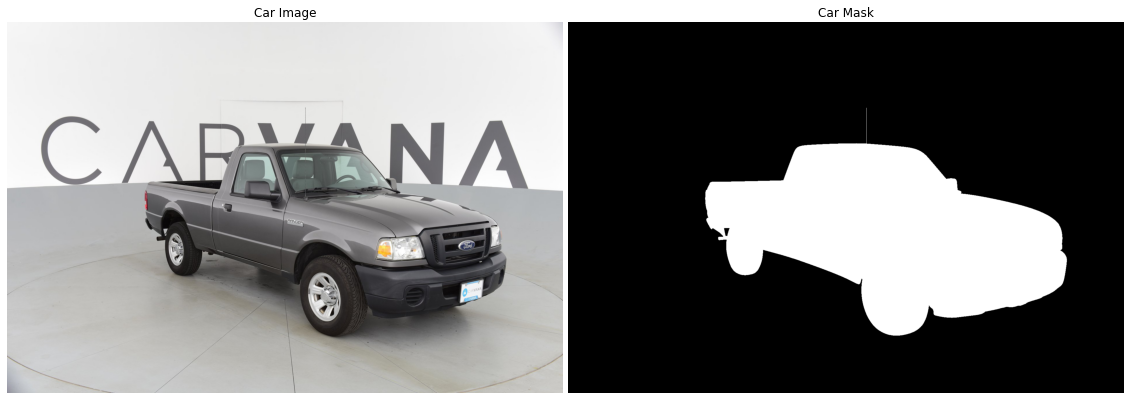

In [5]:
i=110
car_id = car_ids[i]
mask_id = mask_ids[i]

car = load_img('/kaggle/working/train_hq/' + car_id)
mask = load_img('/kaggle/working/train_masks/' + mask_id)

plt.figure(figsize=(19,15))


fig, ax = plt.subplots(1, 2, figsize=(20,20))
fig.subplots_adjust(hspace=.1, wspace=.01)

ax[0].imshow(car)
ax[0].axis('off')
ax[0].title.set_text('Car Image')
ax[1].imshow(mask)
ax[1].axis('off')
ax[1].title.set_text('Car Mask')



In [6]:
mask_ids=np.asarray(mask_ids)


In [7]:

mask_ids.shape

(5088,)

In [8]:
car_ids = np.asarray(car_ids)
car_ids.shape

(5088,)

In [9]:


def data_split(X,y,train_ratio, validation_ratio, test_ratio):
    x_train, x_test, y_train, y_test = train_test_split(X, y,  test_size=1 - train_ratio,random_state=4)

    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test , test_size=test_ratio/(test_ratio + validation_ratio)) 


    return x_train, x_val, x_test, y_train, y_val, y_test


train_ratio = 0.65
validation_ratio = 0.05
test_ratio = 0.30

##### IMPORTANT TO SORT LISTS ########
# car ids
X = sorted(os.listdir('/kaggle/working/train_hq'))

# mask ids
y = sorted(os.listdir('/kaggle/working/train_masks'))
######################################



X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,train_ratio, validation_ratio, test_ratio)


print(len(X_train))
print(len(X_val))
print(len(X_test))
    

3307
254
1527


In [10]:
X_train=np.array(X_train)
X_val=np.array(X_val)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

In [11]:
# pd= DataFrame(X_train,X_val,X_test,y_train,y_val,y_test,column=["X_train","X_val","X_test","y_train","y_val","y_test"])

[ 342 1223  832  192]


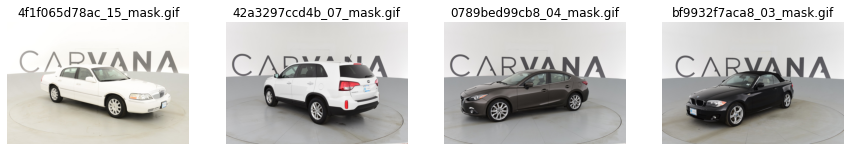

In [12]:
plt.figure(figsize=(15,10))
inx = np.random.choice(len(X_test), 4, replace=True)
print(inx)
for n, i in enumerate(inx):
    ax = plt.subplot(1,4,n+1)
    plt.imshow(io.imread('/kaggle/working/train_hq/'+X_train[i]))
    plt.title(y_train[i])
    plt.axis('off')

[ 342 1223  832  192]


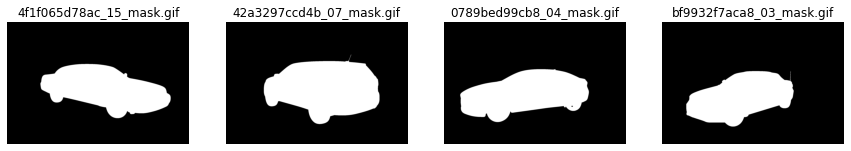

In [13]:
plt.figure(figsize=(15,10))
# inx = np.random.choice(len(X_test), 4, replace=True)
print(inx)
for n, i in enumerate(inx):
    ax = plt.subplot(1,4,n+1)
    plt.imshow(io.imread('/kaggle/working/train_masks/'+y_train[i]),cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')

In [14]:
print(X_train.shape, X_val.shape, X_test.shape,    y_train.shape, y_val.shape, y_test.shape)

(3307,) (254,) (1527,) (3307,) (254,) (1527,)


In [15]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [16]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [18]:



def load_images(images,masks, PATH_TRAIN, PATH_MASK,IMG_SIZE): 

    car_images=[]
    mask_images=[]
    
    
    
    for i in range(len(images)):
        image = images[i]
        mask =masks[i]
        
        car_image =load_img(PATH_TRAIN+image,target_size= IMG_SIZE )
              
        mask_image= load_img(PATH_MASK+mask,target_size= IMG_SIZE[:-1], color_mode = 'grayscale') 
        
        car_image =img_to_array(car_image)
        mask_image=img_to_array(mask_image)
        
        car_images.append(car_image)
        mask_images.append(mask_image)
    
    return car_images, mask_images




# if tf.config.experimental.list_physical_devices("GPU"):
#     print("On GPU:")
#     with tf.device("GPU:0"): 
PATH_X="/kaggle/working/train_hq/" 
PATH_y="/kaggle/working/train_masks/"       
IMG_SIZE=[128,128,3]
data_train,mask_train = load_images(X_train,y_train, PATH_X, PATH_y,IMG_SIZE)        
data_val,mask_val = load_images(X_val,y_val, PATH_X, PATH_y,IMG_SIZE)  
data_test,mask_test = load_images(X_test,y_test, PATH_X, PATH_y,IMG_SIZE)     



    
               

In [19]:
X_train =np.array(data_train)
X_val   =np.array(data_val)
X_test  =np.array(data_test)
y_train =np.array(mask_train)
y_val   =np.array(mask_val)
y_test  =np.array(mask_test)


X_val   = np.array(X_val, dtype=np.float32) / 255.
y_val   = np.array(y_val, dtype=np.float32) / 255.
             
X_train = np.array(X_train, dtype=np.float32) / 255.
y_train = np.array(y_train, dtype=np.float32) / 255.
             
X_test  = np.array(X_test, dtype=np.float32) / 255.
y_test  = np.array(y_test, dtype=np.float32) / 255.

In [20]:
print(" X_train:",X_train.shape,"\n","X_val: ", X_val.shape,"\n","X_test: ",\
      X_test.shape, "\n","y_train:",y_train.shape,"\n","y_val :", y_val.shape,"\n","y_test:", y_test.shape)

 X_train: (3307, 128, 128, 3) 
 X_val:  (254, 128, 128, 3) 
 X_test:  (1527, 128, 128, 3) 
 y_train: (3307, 128, 128, 1) 
 y_val : (254, 128, 128, 1) 
 y_test: (1527, 128, 128, 1)


In [21]:
X_val[1].shape

(128, 128, 3)

<Figure size 1368x1080 with 0 Axes>

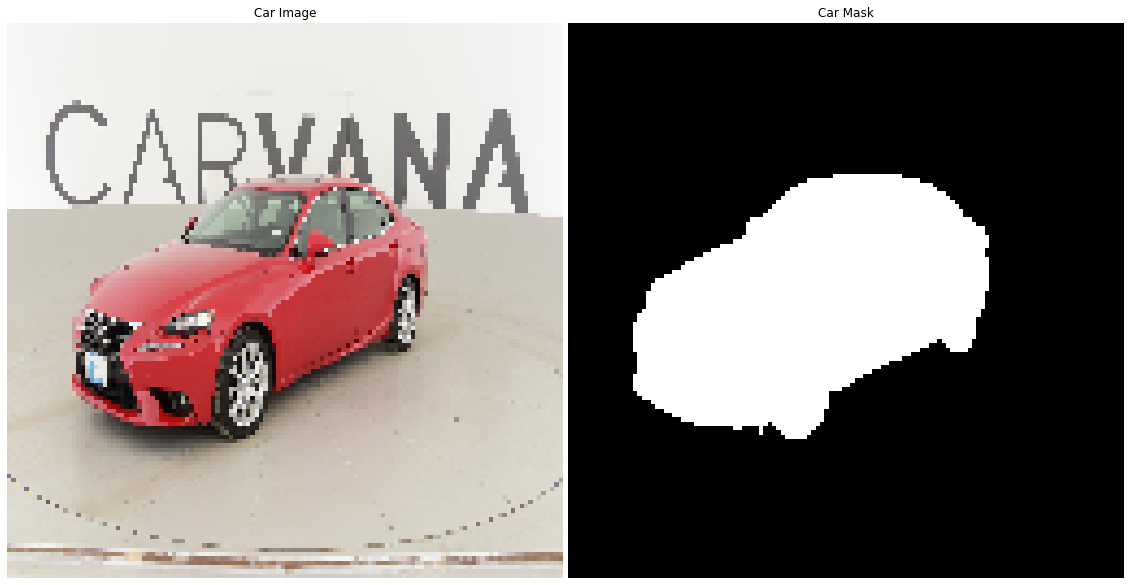

In [22]:
i=0

car=X_val[i]
mask=y_val[i]

# car=X_train[i]
# mask=y_train[i]

# car=X_test[i]
# mask=y_test[i]

mask=mask[:,:,0]

plt.figure(figsize=(19,15))


fig, ax = plt.subplots(1, 2, figsize=(20,20))
fig.subplots_adjust(hspace=.1, wspace=.01)

ax[0].imshow(car)
ax[0].axis('off')
ax[0].title.set_text('Car Image')
ax[1].imshow(mask, cmap='gray')
ax[1].axis('off')
ax[1].title.set_text('Car Mask')


In [23]:


BATCH_SIZE=16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset  = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset  = test_dataset.batch(BATCH_SIZE)


val_dataset  = tf.data.Dataset.from_tensor_slices((X_val,y_val))
val_dataset  = val_dataset.batch(BATCH_SIZE)



In [24]:
print(train_dataset.element_spec)
print(test_dataset.element_spec)
print(val_dataset.element_spec)

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))


In [25]:
def dice_coef(y_true, y_pred):
    '''
    Metric
    '''
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    '''
    Loss function
    '''
    loss = 1 - dice_coef(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    '''
    Mixed crossentropy and dice loss.
    '''
    loss = keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [26]:
def get_unet_128(input_shape=(128, 128, 3),
                 num_classes=1):
    inputs = Input(shape=input_shape)
    # 128

    down1 = Conv2D(64, (3, 3), padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 128

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)

    model.compile(optimizer=RMSprop(lr=0.0001), loss=bce_dice_loss, metrics=[dice_coef])

    return model

model = get_unet_128()

In [27]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [28]:
LR_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',\
                                                patience=2, verbose=10, factor=.2, min_lr=.00001)



EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_loss',\
                                                   patience=10, restore_best_weights=True)


def get_checkpoint_entire_model():
 
    checkpoint= ModelCheckpoint('../working/savedmodel/checkpoint_{epoch:02d}',\
                                             save_weight_only=False)
    return checkpoint

# def get_checkpoint_entire_model():
 
#     checkpoint= ModelCheckpoint('../working/savedmodel/checkpoint_{epoch:02d}_{batch:04d}',\
#                                              save_weight_only=False)
#     return checkpoint

def get_checkpoint_every_epoch():
    checkpoint = ModelCheckpoint('../working/savedmodel/checkpoint_{epoch:03d}',\
                                 save_weights_only=True)
    
    return checkpoint


def get_checkpoint_best_only():

    checkpoint = ModelCheckpoint('../working/savedmodel/model',
                                 save_best_only=True,
                                 save_weights_only=True)
                                                              
    return checkpoint

callbacks_list=[get_checkpoint_best_only(),get_checkpoint_every_epoch(),get_checkpoint_entire_model()]

In [29]:
print(train_dataset.element_spec)
print(test_dataset.element_spec)
print(val_dataset.element_spec)

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))


In [30]:

# X_train
# X_val  
# X_test 
# y_train
# y_val  
# y_test 

def train_model(model, train_dataset, val_dataset):
    BATCH_SIZE=16
    train_dataset= train_dataset.repeat()
    
    history = model.fit(train_dataset,validation_data=val_dataset,epochs=30,\
                        steps_per_epoch=X_train.shape[0]//BATCH_SIZE ,\
                        callbacks=[LR_callback, EarlyStop_callback,\
                                   callbacks_list])
    
    return history


# if tf.config.experimental.list_physical_devices("GPU"):
#     print("On GPU:")
#     with tf.device("GPU:0"): 
        
history = train_model(model, train_dataset,val_dataset)
model.save_weights('../working/saved_weights/model')
model.save('../working/saved_model/entire_model')
        
        



Epoch 1/30
206/206 [==============================] - 48s 232ms/step - loss: 0.1970 - dice_coef: 0.8828 - val_loss: 1.6212 - val_dice_coef: 0.0721
Epoch 2/30
206/206 [==============================] - 47s 227ms/step - loss: 0.0866 - dice_coef: 0.9470 - val_loss: 1.2362 - val_dice_coef: 0.3569
Epoch 3/30
206/206 [==============================] - 47s 227ms/step - loss: 0.0557 - dice_coef: 0.9665 - val_loss: 0.0625 - val_dice_coef: 0.9642
Epoch 4/30
206/206 [==============================] - 47s 231ms/step - loss: 0.0390 - dice_coef: 0.9773 - val_loss: 0.0355 - val_dice_coef: 0.9799
Epoch 5/30
206/206 [==============================] - 47s 226ms/step - loss: 0.0296 - dice_coef: 0.9834 - val_loss: 0.0293 - val_dice_coef: 0.9842
Epoch 6/30
206/206 [==============================] - 48s 231ms/step - loss: 0.0241 - dice_coef: 0.9869 - val_loss: 0.0283 - val_dice_coef: 0.9858
Epoch 7/30
206/206 [==============================] - 47s 226ms/step - loss: 0.0205 - dice_coef: 0.9891 - val_loss: 0.

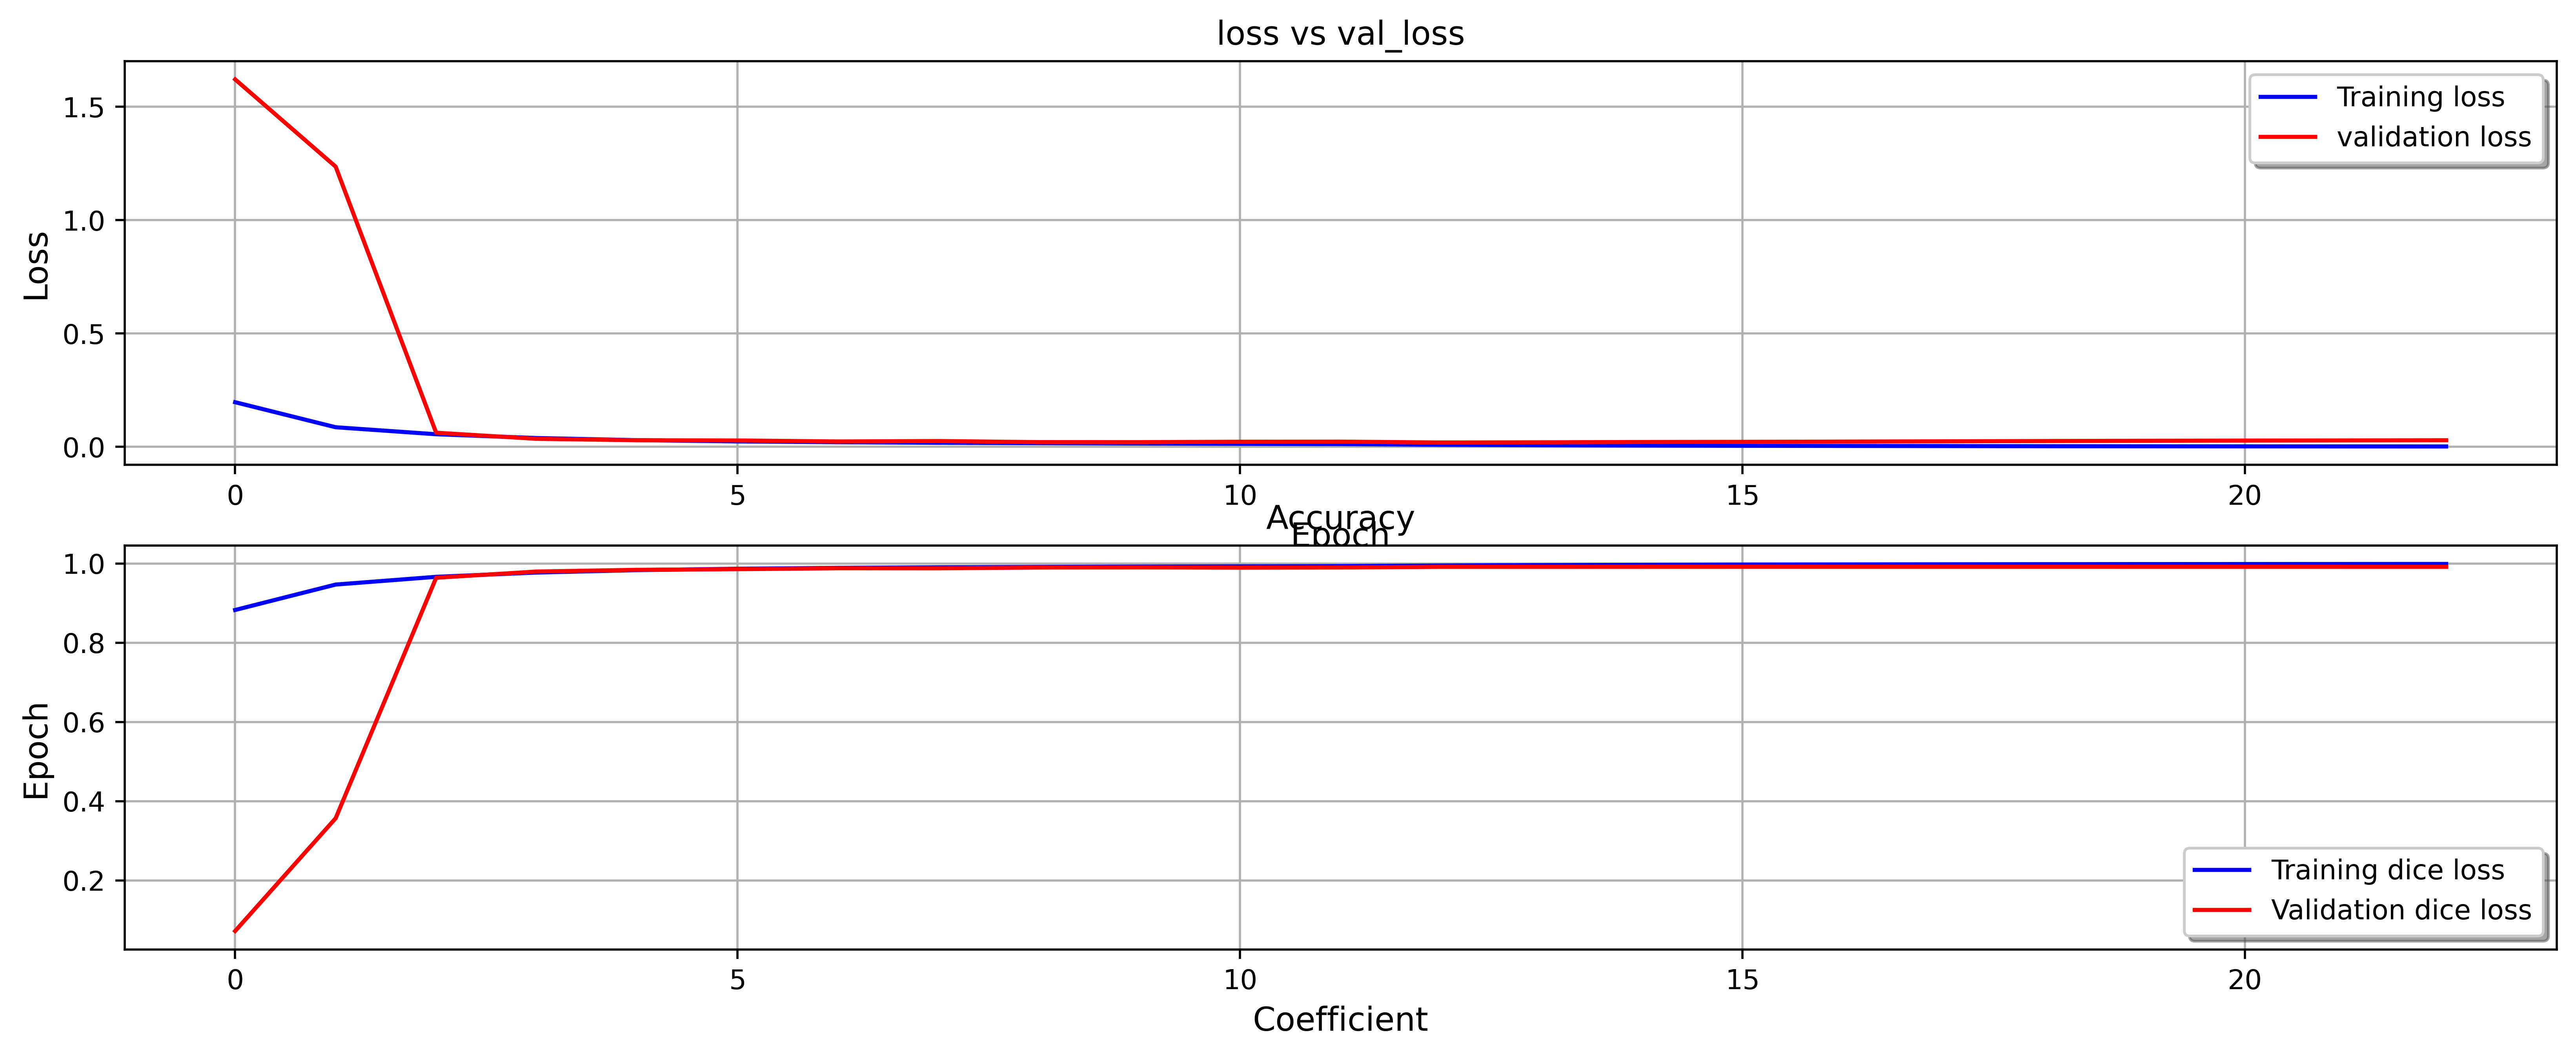

In [31]:
# Plot the loss and accuracy curves for training and validation

fig, ax = plt.subplots(2,1,figsize = (16,6), dpi = 500)

ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].set_title('loss vs val_loss', fontdict={'fontsize': 12, 'fontweight': 'medium'})
ax[0].set_xlabel('Epoch', fontsize='12')
ax[0].set_ylabel('Loss', fontsize='12')
ax[0].grid()
legend = ax[0].legend(loc='best', shadow=True)



ax[1].plot(history.history['dice_coef'], color='b', label="Training dice loss")
ax[1].plot(history.history['val_dice_coef'], color='r',label="Validation dice loss")
ax[1].set_title('Accuracy', fontdict={'fontsize': 12, 'fontweight': 'medium'})
ax[1].set_xlabel('Coefficient', fontsize='12')
ax[1].set_ylabel('Epoch', fontsize='12')
ax[1].grid()
legend = ax[1].legend(loc='best', shadow=True)






In [32]:
X_test.shape

(1527, 128, 128, 3)

In [33]:

#Perdict some imgs.
pred_masks = model.predict(X_test)

# decoded_predictions= tf.keras.applications.imagenet_utils.decode_predictions(pred_masks, top= 3 ) 



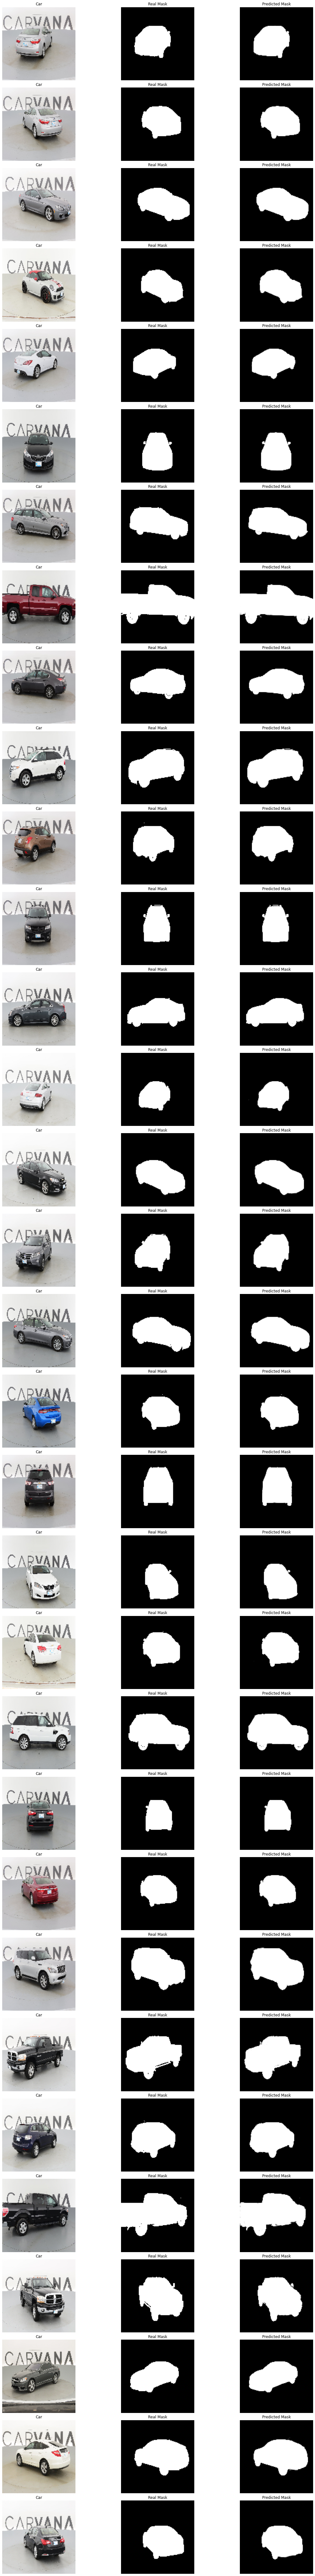

In [34]:
fig, ax = plt.subplots(32, 3, figsize=(20,150))
fig.subplots_adjust(hspace=.1, wspace=.05)
for i in range(32):
    ax[i, 0].imshow(X_test[i].astype(np.float32))
    ax[i, 0].axis('off')
    ax[i, 0].title.set_text('Car')
    
    ax[i, 1].imshow(y_test[i,:,:,0].astype(np.float32), cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 1].title.set_text('Real Mask')
    
    ax[i, 2].imshow(pred_masks[i,:,:,0], cmap='gray')
    ax[i, 2].axis('off')
    ax[i, 2].title.set_text('Predicted Mask')
plt.show() 

In [35]:

# decoded_predictions= tf.keras.applications.imagenet_utils.decode_predictions(pred_masks[i,:,:,0], top= 3 ) 
! ls -lh ../working/saved_model/


total 4.0K
drwxr-xr-x 4 root root 4.0K Dec 31 05:46 entire_model


In [36]:
# from tensorflow.keras.models import load_model
# saved_model=load_model('../working/saved_model/entire_model')
# model = tf.keras.models.load_model('../working/saved_model/entire_model')
"""
ValueError: Unable to restore custom object of type _tf_keras_metric currently.
Please make sure that the layer implements `get_config`and `from_config` when saving. 
In addition, please use the `custom_objects` arg when calling `load_model()`.
"""

'\nValueError: Unable to restore custom object of type _tf_keras_metric currently.\nPlease make sure that the layer implements `get_config`and `from_config` when saving. \nIn addition, please use the `custom_objects` arg when calling `load_model()`.\n'

In [37]:

model = get_unet_128()
model.load_weights('../working/saved_weights/model')
# model.summary()



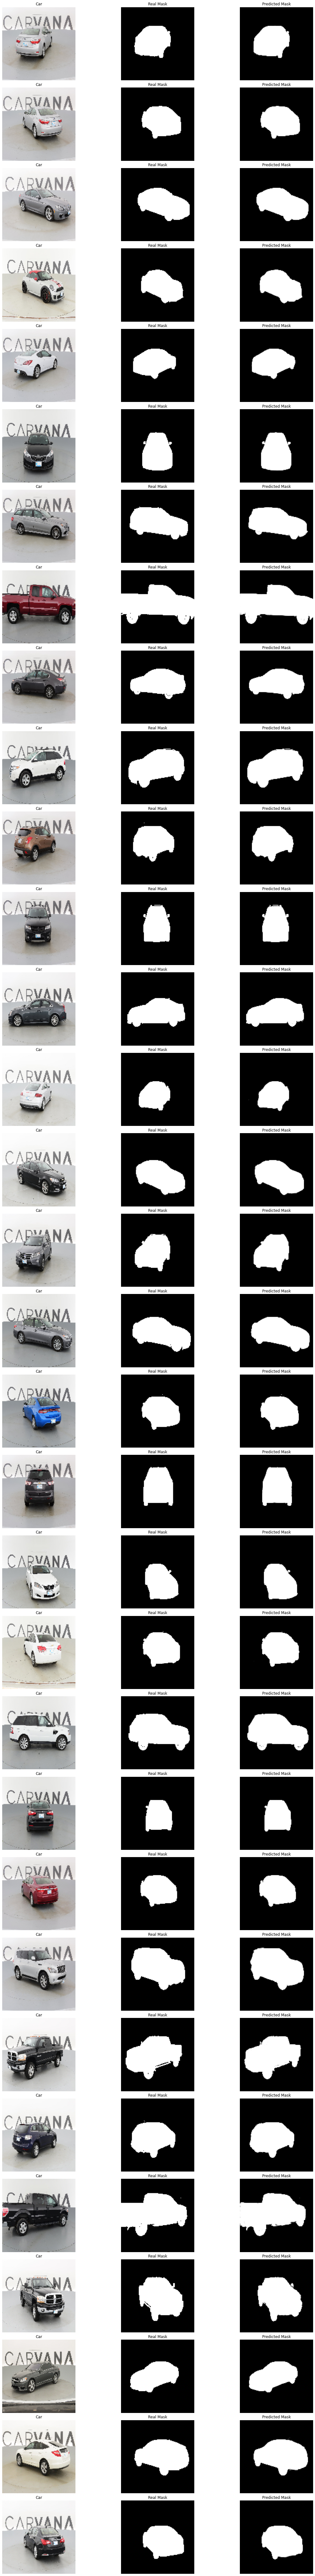

In [38]:
fig, ax = plt.subplots(32, 3, figsize=(20,150))
fig.subplots_adjust(hspace=.1, wspace=.05)
for i in range(32):
    ax[i, 0].imshow(X_test[i].astype(np.float32))
    ax[i, 0].axis('off')
    ax[i, 0].title.set_text('Car')
    
    ax[i, 1].imshow(y_test[i,:,:,0].astype(np.float32), cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 1].title.set_text('Real Mask')
    
    ax[i, 2].imshow(pred_masks[i,:,:,0], cmap='gray')
    ax[i, 2].axis('off')
    ax[i, 2].title.set_text('Predicted Mask')
plt.show() 

In [39]:
sample_ids = sorted(os.listdir('../input/samplecar'))

In [40]:
sample_ids

['sample-00001.jpg',
 'sample-00001_cut.jpg',
 'sample-00002.jpg',
 'sample-00002_cut.jpg',
 'sample-00003.jpg',
 'sample-00003_cut.jpg',
 'sample-00004.jpg',
 'sample-00004_cut.jpg',
 'sample-00005.jpg',
 'sample-00005_cut.jpg',
 'sample-00006.jpg',
 'sample-00006_cut.jpg',
 'sample-00007.jpg',
 'sample-00007_cut.jpg',
 'sample-00009.jpg',
 'sample-00009_cut.jpg',
 'sample-00010.jpg',
 'sample-00010_cut.jpg',
 'sample-00011.jpg',
 'sample-00011_cut.jpg',
 'sample-00012.jpg',
 'sample-00012_cut.jpg',
 'sample-00013.jpg',
 'sample-00013_cut.jpg',
 'sample-00014.jpg',
 'sample-00014_cut.jpg',
 'sample-00015.jpg',
 'sample-00015_cut.jpg']

(128, 128, 3)

<Figure size 1368x1080 with 0 Axes>

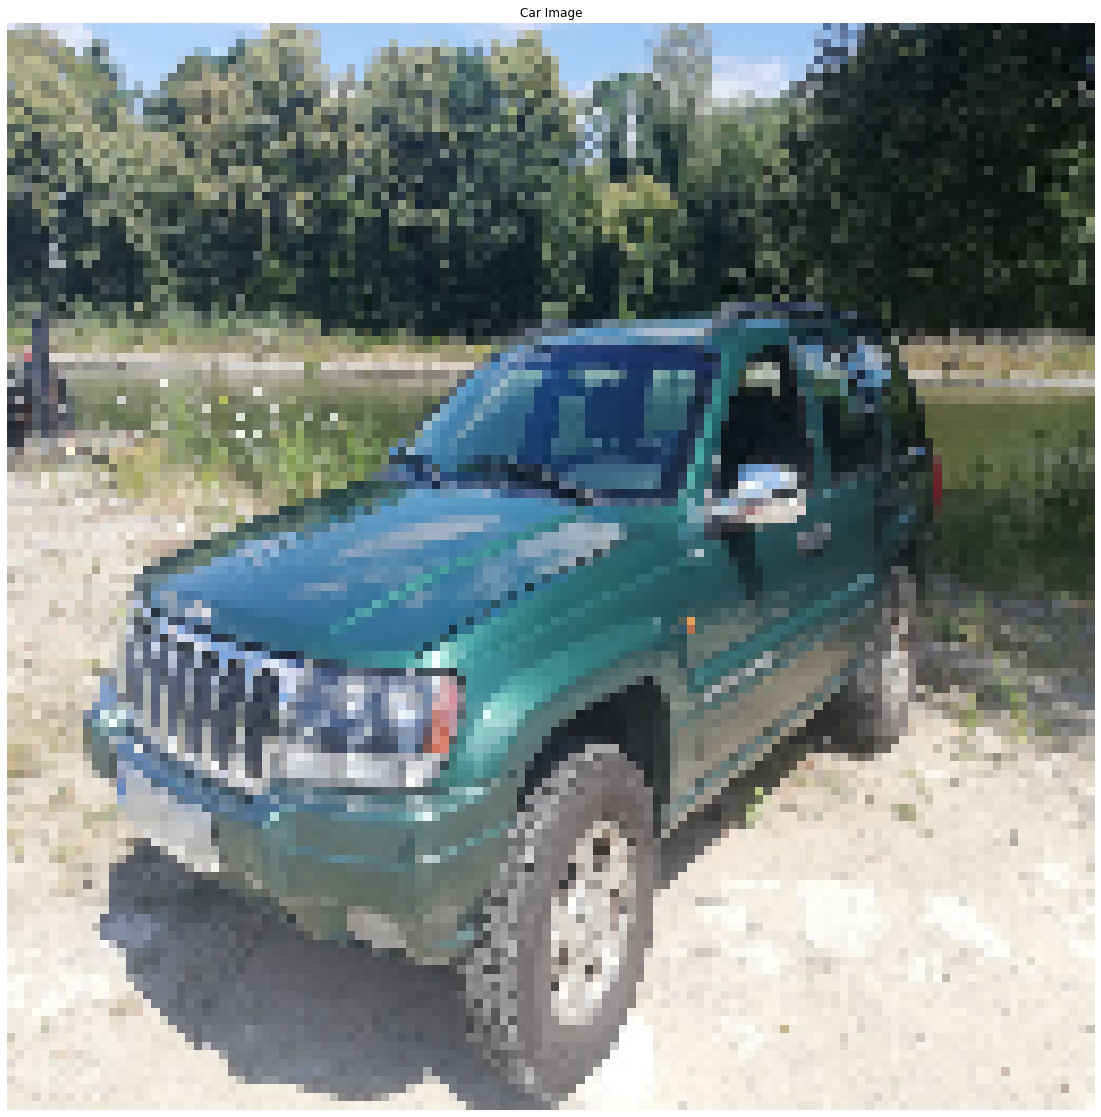

In [41]:



def load_sample_images(images,PATH_SAMPLE,IMG_SIZE): 

    car_images=[]

    for i in range(len(images)):
        image = images[i]        
        car_image =load_img(PATH_SAMPLE+image,target_size= IMG_SIZE )
        car_image =img_to_array(car_image)
        car_image   = np.array(car_image, dtype=np.float32) / 255.
        car_images.append(car_image)
    return car_images


IMG_SIZE=[128,128,3]
PATH_SAMPLE="../input/samplecar/"
sample_ids = sorted(os.listdir('../input/samplecar'))
car_images = load_sample_images(sample_ids,PATH_SAMPLE,IMG_SIZE)
car_images =np.array(car_images)

i=12
car = car_images[i]

# car = load_img('../input/samplecar/' + car_images)
plt.figure(figsize=(19,15))
fig, ax = plt.subplots(1, 1, figsize=(20,20))
# fig.subplots_adjust(hspace=.1, wspace=.01)
ax.imshow(car)
ax.axis('off')
ax.title.set_text('Car Image')

car.shape

In [42]:
car_images.shape

(28, 128, 128, 3)

In [43]:
pred_sample_masks = model.predict(car_images)

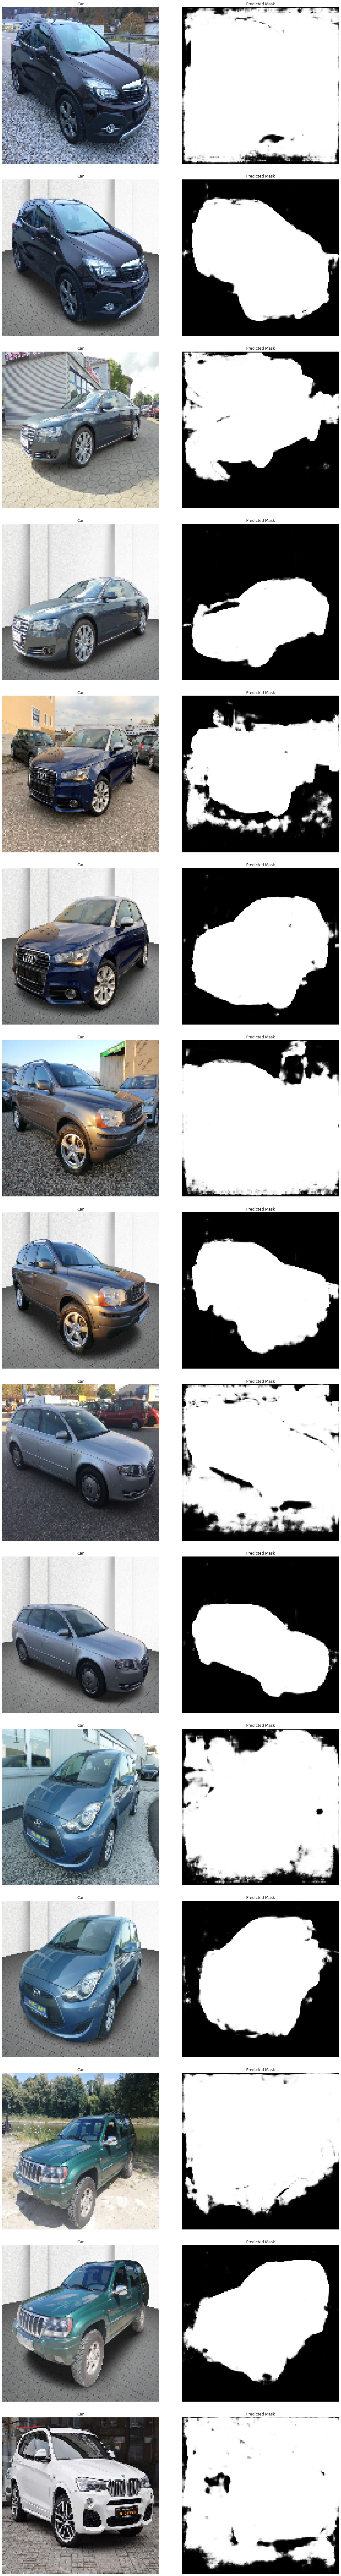

In [44]:
fig, ax = plt.subplots(15, 2, figsize=(20,150))
fig.subplots_adjust(hspace=.1, wspace=.05)
for i in range(15):
    ax[i, 0].imshow(car_images[i].astype(np.float32))
    ax[i, 0].axis('off')
    ax[i, 0].title.set_text('Car')
    
#     ax[i, 1].imshow(pred_sample_masks[i,:,:,0].astype(np.float32), cmap='gray')
#     ax[i, 1].axis('off')
#     ax[i, 1].title.set_text('Real Mask')
    
    ax[i, 1].imshow(pred_sample_masks[i,:,:,0], cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 1].title.set_text('Predicted Mask')
plt.show() 